# Предложения для постоянных клиентов онлайн-магазина

**Заказчик исследования:** Интернет-магазин «В один клик».

**Цель проекта:** разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Полученные данные:** данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении и о прибыли, которую получает магазин от продаж каждому покупателю за последние 3 мес.

**План работы:**
1. Изучить полученные данные - обработать пропуски, выявить и устранить аномалии и пропуски в данных.
2. Изучить корреляции и связи между признаками.
3. Обучить несколько моделей. Выбрать лучшую модель по подходящей метрике с помощью пайплайнов.
4. Проанализировать важность признаков лучшей модели. Выработать рекомендации для компании на основе анализа признаков.
5. Сегментировать покупателей и сделать предложения по работе с сегментом для увеличения покупательской активности.

In [258]:
!pip install phik
!pip install shap
!pip install scikit-learn==1.1.3 -q

In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import math
import numpy as np
import warnings
import shap
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

## Загрузка данных

### Загрузка и сохранение полученных данных

In [260]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

### Изучение полученных данных

In [261]:
display(market_file.head())
display(market_money.head())
display(market_time.head())
display(money.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


полученные данные соответствуют описанию

## Предобработка данных

### Изучение общей информации о полученных данных

In [262]:
def data_info(df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        df.info()
        print('*'*100)
        display(df.head(10))
        print('*'*100)
        display(df.min())
        print('*'*100)
        display(df.max())
        print('*'*100)
        display(df[df.duplicated() == True])
        print('*'*100)
        df.hist(figsize=(16, 8))
        print('*'*100)
        display(df.describe())
        print('*'*100)
        plt.show();

Создаём фунцию для общего анализа датафрейма.

#### Информация о поведении покупателей

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


****************************************************************************************************


id                                                215348
Покупательская активность                Прежний уровень
Тип сервиса                                      премиум
Разрешить сообщать                                    да
Маркет_актив_6_мес                                   0.9
Маркет_актив_тек_мес                                   3
Длительность                                         110
Акционные_покупки                                    0.0
Популярная_категория                   Домашний текстиль
Средний_просмотр_категорий_за_визит                    1
Неоплаченные_продукты_штук_квартал                     0
Ошибка_сервиса                                         0
Страниц_за_визит                                       1
dtype: object

****************************************************************************************************


id                                               216647
Покупательская активность                     Снизилась
Тип сервиса                                   стандартт
Разрешить сообщать                                  нет
Маркет_актив_6_мес                                  6.6
Маркет_актив_тек_мес                                  5
Длительность                                       1079
Акционные_покупки                                  0.99
Популярная_категория                   Товары для детей
Средний_просмотр_категорий_за_визит                   6
Неоплаченные_продукты_штук_квартал                   10
Ошибка_сервиса                                        9
Страниц_за_визит                                     20
dtype: object

****************************************************************************************************


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит


****************************************************************************************************
****************************************************************************************************


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


****************************************************************************************************


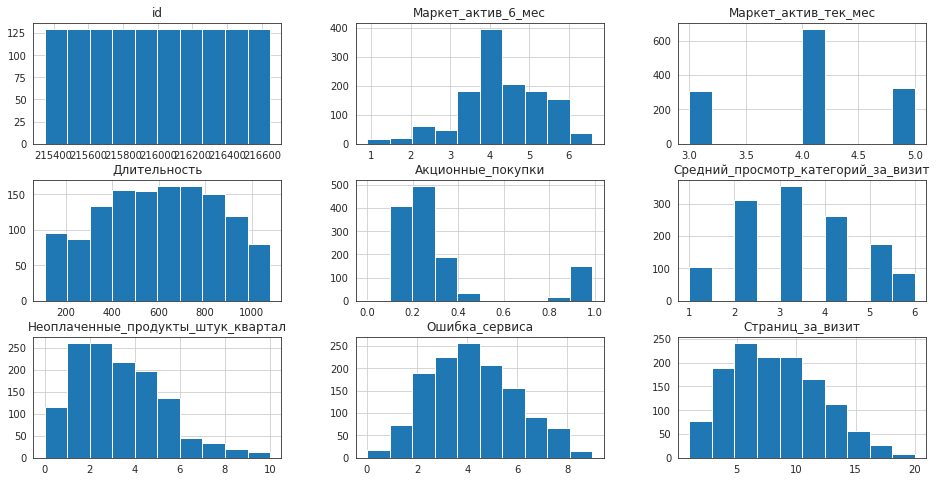

In [263]:
data_info(market_file)

**Выводы:**
- явных выбросов в данных не наблюдается;
- в датафрейме нет дубликатов;
- пропуски в данных отсутствуют;
- распределение в столбцах `Средний_просмотр_категорий_за_визит`, `Ошибка_сервиса` похоже на нормальное;
- распределения в столбцах `Акционные_покупки`, `Неоплаченные_продукты_штук_квартал`, `Страниц_за_визит` скошены в лево.

#### Информация о выручке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
****************************************************************************************************


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


****************************************************************************************************


id                   215348
Период     предыдущий_месяц
Выручка                 0.0
dtype: object

****************************************************************************************************


id                216647
Период     текущий_месяц
Выручка         106862.2
dtype: object

****************************************************************************************************


,id,Период,Выручка


****************************************************************************************************
****************************************************************************************************


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


****************************************************************************************************


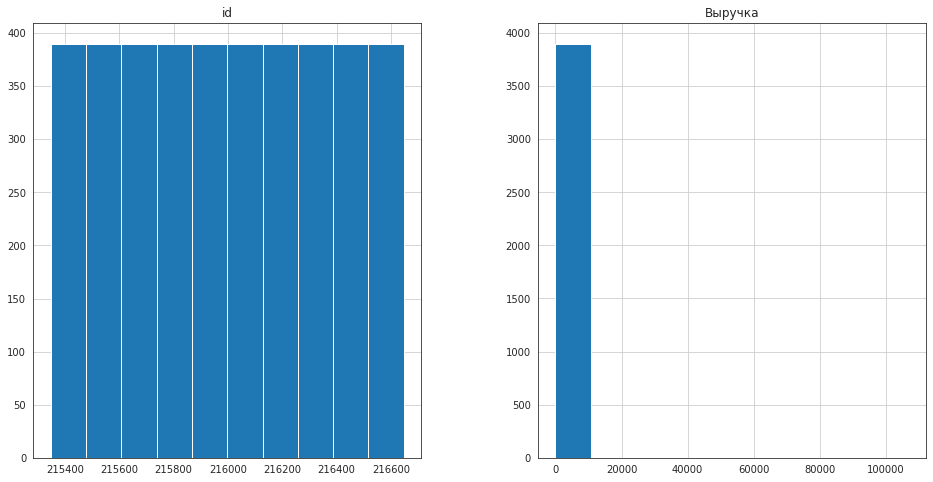

In [264]:
data_info(market_money)

**Выводы:**
- в датафрейме нет дубликатов;
- пропуски в данных отсутствуют;
- в столбцах `Выручка` явно есть выброс.

In [265]:
market_money.sort_values(by = 'Выручка', ascending = False).head()

,id,Период,Выручка
98,215380,текущий_месяц,106862.2
435,215493,текущий_месяц,7799.4
262,215435,текущий_месяц,7605.3
1481,215841,текущий_месяц,7557.0
2388,216144,текущий_месяц,7547.8


Значение выручки 106 тыс. руб. является выбросом - удаляем из таблицы

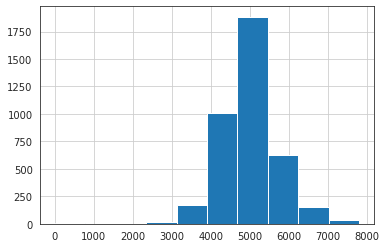

In [266]:
market_money = market_money[market_money['id'] != 215380]
market_money['Выручка'].hist();

#### Информация о времени проведенном на сайте

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
****************************************************************************************************


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


****************************************************************************************************


id                  215348
Период    предыдцщий_месяц
минут                    4
dtype: object

****************************************************************************************************


id               216647
Период    текущий_месяц
минут                23
dtype: object

****************************************************************************************************


,id,Период,минут


****************************************************************************************************
****************************************************************************************************


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


****************************************************************************************************


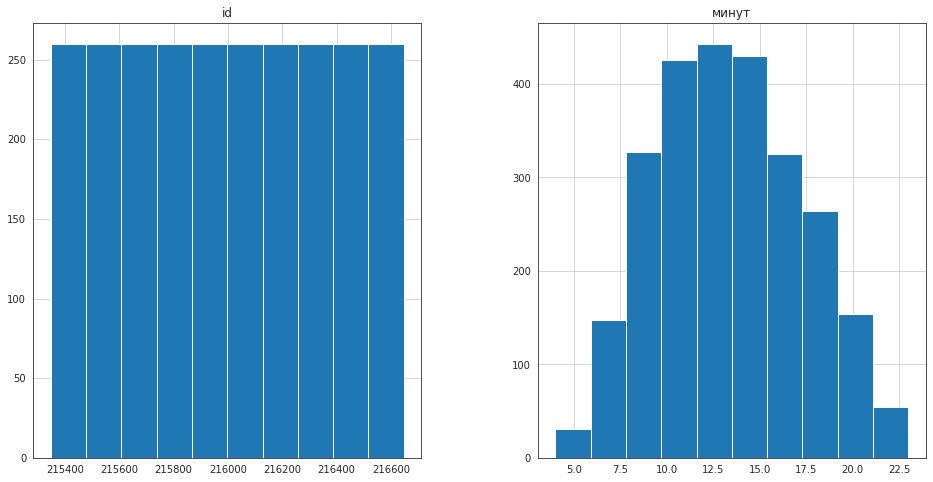

In [267]:
data_info(market_time)

**Выводы:**
- в датафрейме нет дубликатов;
- пропуски в данных отсутствуют;
- распределение в столбце `минут` похоже на нормальное.

#### Информация о прибыли

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
****************************************************************************************************


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


****************************************************************************************************


id         215348.00
Прибыль         0.86
dtype: float64

****************************************************************************************************


id         216647.00
Прибыль         7.43
dtype: float64

****************************************************************************************************


,id,Прибыль


****************************************************************************************************
****************************************************************************************************


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


****************************************************************************************************


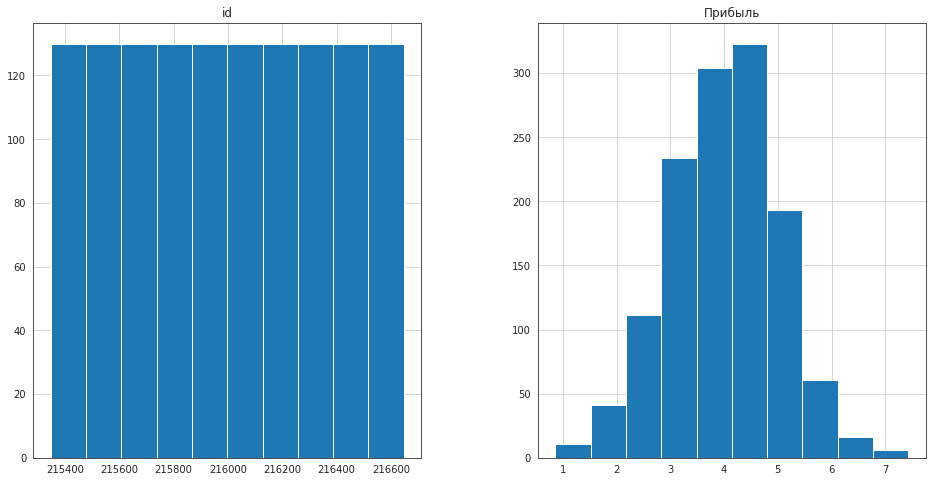

In [268]:
data_info(money)

**Выводы:**
- в датафрейме нет дубликатов;
- пропуски в данных отсутствуют;
- распределение в столбце `Прибыль` похоже на нормальное.

## Исследовательский анализ данных

In [269]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


### Столбец - Покупательская активность

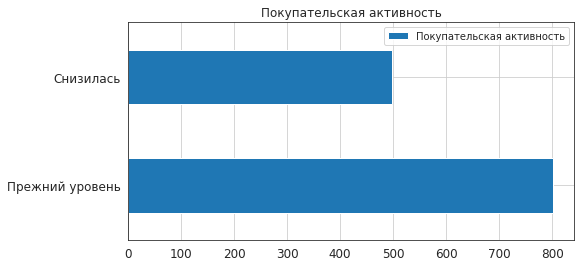

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

In [270]:
market_file['Покупательская активность'].value_counts().plot(
    kind = 'barh',
    title = 'Покупательская активность', 
    legend = True,
    grid = True,
    ylabel = 'Количесво',
    xlabel = '',
    fontsize = 12,
    figsize = (8, 4)
)
plt.show();
display(market_file['Покупательская активность'].value_counts())

**Выводы:**
- покупателей с прежней активностью больше чем покупателей со снизисившейся (802 и 498 покупателей соответственно)

### Столбец - Тип сервиса

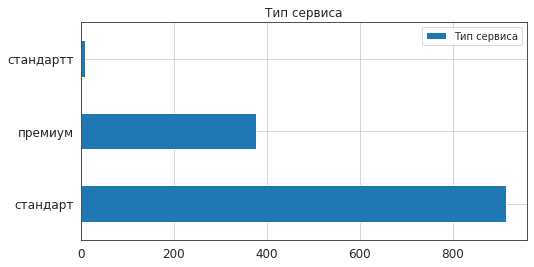

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

In [271]:
market_file['Тип сервиса'].value_counts().plot(
    kind = 'barh',
    title = 'Тип сервиса', 
    legend = True,
    grid = True,
    ylabel = 'Количесво',
    xlabel = '',
    fontsize = 12,
    figsize = (8, 4)
)
plt.show();
display(market_file['Тип сервиса'].value_counts())

Наблюдается неявный дубликат в наименовании типа сервиса.

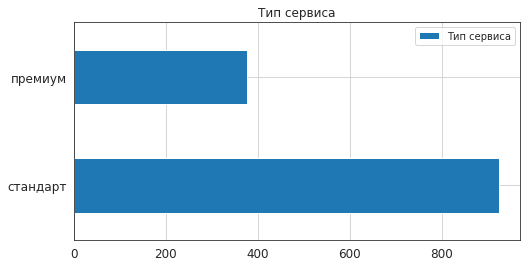

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64

In [272]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('стандартт', 'стандарт')

market_file['Тип сервиса'].value_counts().plot(
    kind = 'barh',
    title = 'Тип сервиса', 
    legend = True,
    grid = True,
    ylabel = 'Количесво',
    xlabel = '',
    fontsize = 12,
    figsize = (8, 4)
)
plt.show();
display(market_file['Тип сервиса'].value_counts())

**Выводы:**
- у большинства покупателей стандартный уровень сервиса

### Столбец - Разрешить сообщать

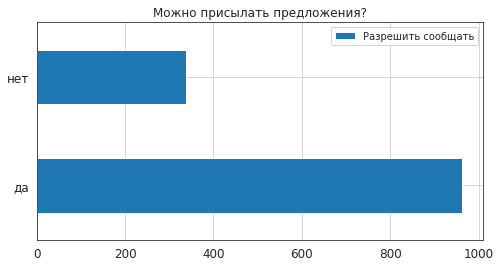

да     962
нет    338
Name: Разрешить сообщать, dtype: int64

In [273]:
market_file['Разрешить сообщать'].value_counts().plot(
    kind = 'barh',
    title = 'Можно присылать предложения?', 
    legend = True,
    grid = True,
    ylabel = 'Количесво',
    xlabel = '',
    fontsize = 12,
    figsize = (8, 4)
)
plt.show();
display(market_file['Разрешить сообщать'].value_counts())

**Выводы:**
- большинства покупателей дали согласие на рассылку предложений

### Столбец - Маркет актив 6 мес

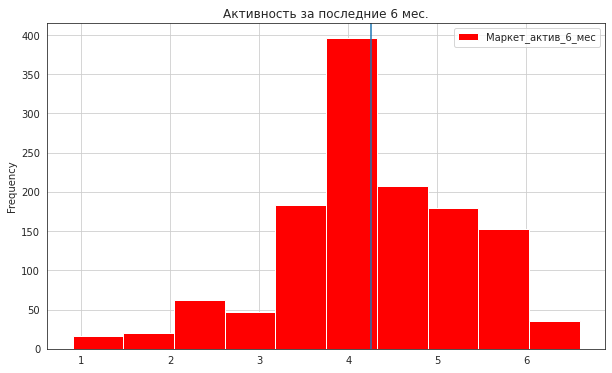

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

In [274]:
market_file['Маркет_актив_6_мес'].plot(
    kind = 'hist',
    bins = 10,
    title = 'Активность за последние 6 мес.', 
    legend = True, 
    grid = True,
    figsize = (10, 6),
    color = 'r'
)
plt.axvline (x=market_file['Маркет_актив_6_мес'].mean()) 
plt.show();
display(market_file['Маркет_актив_6_мес'].describe())

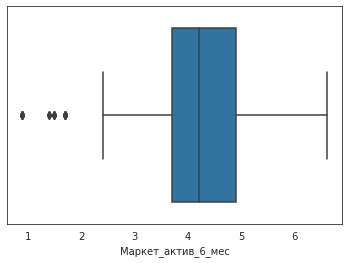

In [275]:
sns.boxplot(x=market_file['Маркет_актив_6_мес']);

**Выводы:**
- в среднем за предыдущие пол года с клиентами коммуницируют 4 раза в месяц.

### Столбец - Маркет актив тек мес

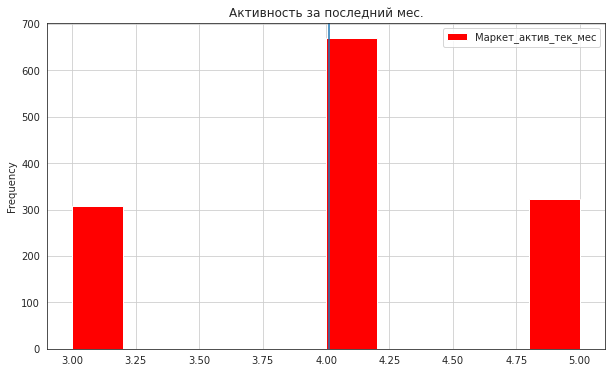

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64

In [276]:
market_file['Маркет_актив_тек_мес'].plot(
    kind = 'hist',
    bins = 10,
    title = 'Активность за последний мес.', 
    legend = True, 
    grid = True,
    figsize = (10, 6),
    color = 'r'
)
plt.axvline (x=market_file['Маркет_актив_тек_мес'].mean()) 
plt.show();
display(market_file['Маркет_актив_тек_мес'].describe())

**Выводы:**
- аналогично предыдущему графику.

### Столбец - Длительность

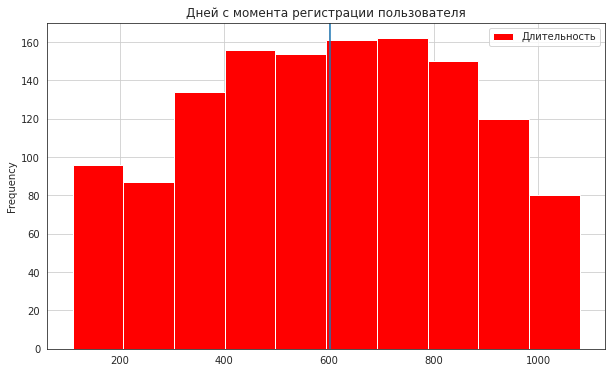

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

In [277]:
market_file['Длительность'].plot(
    kind = 'hist',
    bins = 10,
    title = 'Дней с момента регистрации пользователя', 
    legend = True, 
    grid = True,
    figsize = (10, 6),
    color = 'r'
)
plt.axvline (x=market_file['Длительность'].mean()) 
plt.show();
display(market_file['Длительность'].describe())

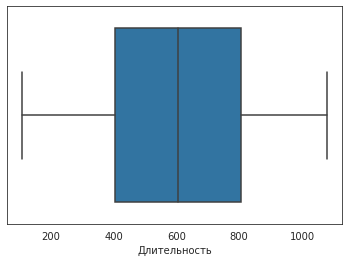

In [278]:
sns.boxplot(x=market_file['Длительность']);

**Выводы:**
- на графике видно, что пик регистраций был более чем год назад, на текущий момент количество регистраций снижается

### Столбец - Акционные_покупки

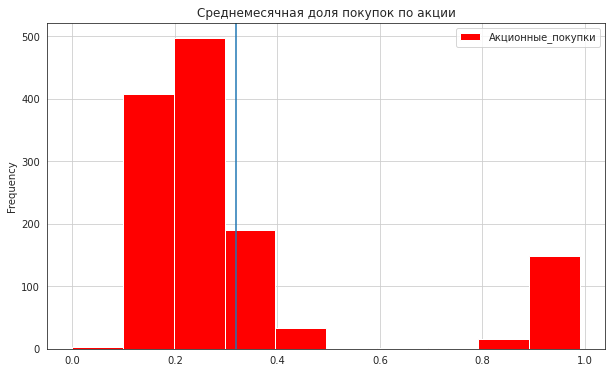

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

In [279]:
market_file['Акционные_покупки'].plot(
    kind = 'hist',
    bins = 10,
    title = 'Среднемесячная доля покупок по акции', 
    legend = True, 
    grid = True,
    figsize = (10, 6),
    color = 'r'
)
plt.axvline (x=market_file['Акционные_покупки'].mean()) 
plt.show();
display(market_file['Акционные_покупки'].describe())

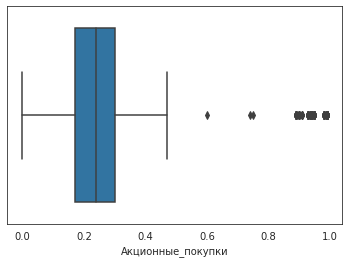

In [280]:
sns.boxplot(x=market_file['Акционные_покупки']);

**Выводы:**
- в среднем доля покупок по акции составляет 32%, при этом есть доля покупателей, которые совершают покупки только по акции

### Столбец - Популярная_категория

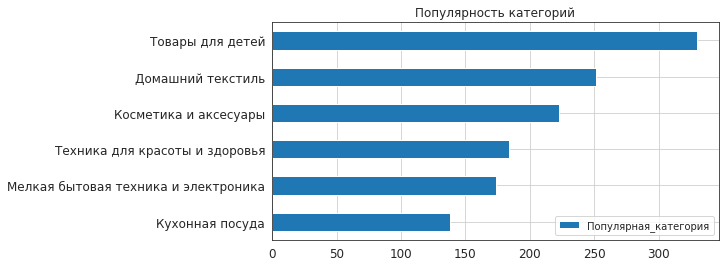

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

In [281]:
market_file['Популярная_категория'].value_counts(ascending = True).plot(
    kind = 'barh',
    title = 'Популярность категорий', 
    legend = True,
    grid = True,
    ylabel = 'Количесво',
    xlabel = '',
    fontsize = 12,
    figsize = (8, 4)
)
plt.show();
display(market_file['Популярная_категория'].value_counts())

**Выводы:**
- наиболее популярной категорией покупоки являются товары для детей

### Столбец - Средний_просмотр_категорий_за_визит

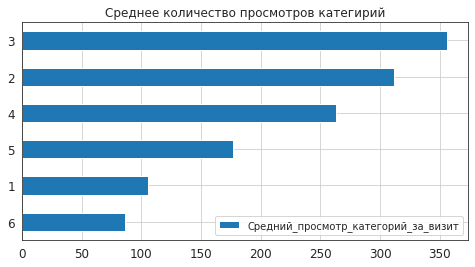

3    356
2    312
4    263
5    177
1    106
6     86
Name: Средний_просмотр_категорий_за_визит, dtype: int64

In [282]:
market_file['Средний_просмотр_категорий_за_визит'].value_counts(ascending = True).plot(
    kind = 'barh',
    title = 'Среднее количество просмотров категирий', 
    legend = True,
    grid = True,
    ylabel = 'Количесво',
    xlabel = '',
    fontsize = 12,
    figsize = (8, 4)
)
plt.show();
display(market_file['Средний_просмотр_категорий_за_визит'].value_counts())

**Выводы:**
- в среднем покупатели просматривают 2 и 3 категории товаров, при этом покупателей, которые просматривают 1 или все 6 категорий наименьшее количество.

### Столбец - Неоплаченные_продукты_штук_квартал

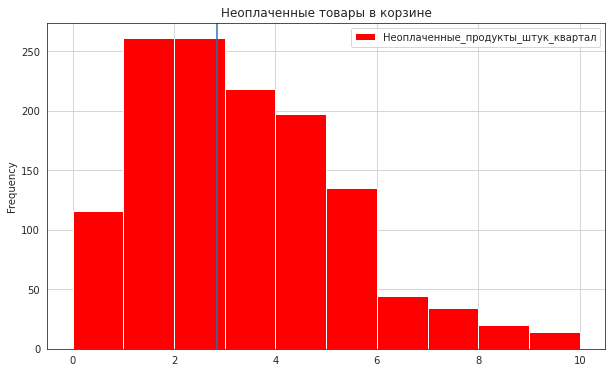

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

In [283]:
market_file['Неоплаченные_продукты_штук_квартал'].plot(
    kind = 'hist',
    bins = 10,
    title = 'Неоплаченные товары в корзине', 
    legend = True, 
    grid = True,
    figsize = (10, 6),
    color = 'r'
)
plt.axvline (x=market_file['Неоплаченные_продукты_штук_квартал'].mean()) 
plt.show();
display(market_file['Неоплаченные_продукты_штук_квартал'].describe())

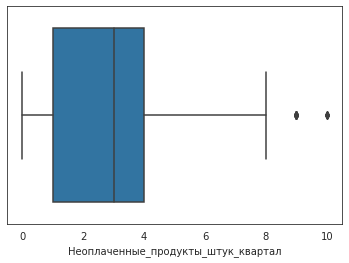

In [284]:
sns.boxplot(x=market_file['Неоплаченные_продукты_штук_квартал']);

<br/>
<div class="alert alert-info">
Видно, что количество неоплаченных товаров в размере 9-10 шт. являются выбросами. При этом, данные значения не являются нереалистичными, поэтому мы их не удаляем.
</div>

**Выводы:**
- в среднем покупатели неоплачивает по 3 товара

### Столбец - Ошибка_сервиса

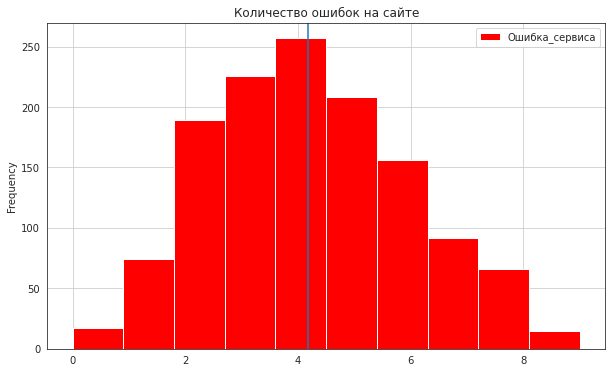

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64

In [285]:
market_file['Ошибка_сервиса'].plot(
    kind = 'hist',
    bins = 10,
    title = 'Количество ошибок на сайте', 
    legend = True, 
    grid = True,
    figsize = (10, 6),
    color = 'r'
)
plt.axvline (x=market_file['Ошибка_сервиса'].mean()) 
plt.show();
display(market_file['Ошибка_сервиса'].describe())

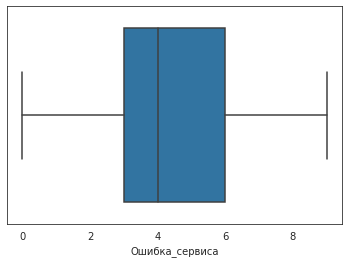

In [286]:
sns.boxplot(x=market_file['Ошибка_сервиса']);

<br/>
<div class="alert alert-info">
Выбросов не наблюдается
</div>

**Выводы:**
- в среднем покупатели сталкиваются с 4 ошибками при посещении сайта

### Столбец - Страниц_за_визит

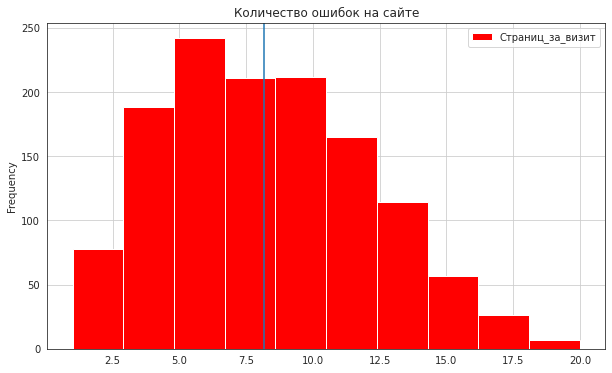

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64

In [287]:
market_file['Страниц_за_визит'].plot(
    kind = 'hist',
    bins = 10,
    title = 'Количество ошибок на сайте', 
    legend = True, 
    grid = True,
    figsize = (10, 6),
    color = 'r'
)
plt.axvline (x=market_file['Страниц_за_визит'].mean()) 
plt.show();
display(market_file['Страниц_за_визит'].describe())

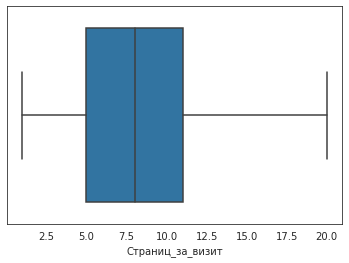

In [288]:
sns.boxplot(x=market_file['Страниц_за_визит']);

<br/>
<div class="alert alert-info">
Выбросов не наблюдается
</div>

**Выводы:**
- в среднем покупатели просматривают 8 страниц сайта

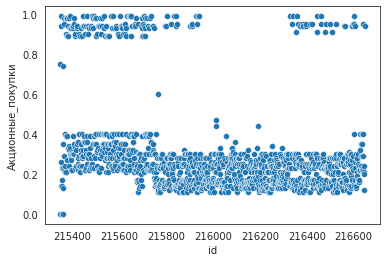

In [289]:
sns.scatterplot(x=market_file['id'], y=market_file['Акционные_покупки'], data=market_file);

<br/>
<div class="alert alert-info">
Номера id увеличиваются равномерно при этом в на графике видно, что в какой-то момент времени клиенты с высокой долей покупок по акциям перестали регистрироваться на сайте. Вероятно это связано с тем, то магазин не предлагал скидоки на товары.
</div>

### Клиенты с покупками в поледние 3 мес.

In [290]:
market_money[market_money['Выручка'] == 0]

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


<br/>
<div class="alert alert-info">
3 id номера с выручкой в предыдущей и препредужущем месяце равной 0.
</div>

In [291]:
market_money = market_money.pivot_table(index = 'id', values = 'Выручка', columns = 'Период')[
    market_money.pivot_table(index = 'id', values = 'Выручка', columns = 'Период')['предыдущий_месяц'] != 0]
market_money.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


**Выводы:**
- по всем 1300 уникальным id пользователей если нанные о покупке за последние 3 мес.

<br/>
<div class="alert alert-info">
Удаляем данные id номера
</div>

## Объединение таблиц

In [292]:
#market_money = market_money.pivot_table(index = 'id', values = 'Выручка', columns = 'Период')
market_money.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
display(market_money.head())
display(market_money.shape)

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


(1296, 3)

In [293]:
market_time = market_time.pivot_table(index = 'id', values = 'минут', columns = 'Период')
market_time.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
display(market_time.head())
display(market_time.shape)

,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


(1300, 2)

In [294]:
market_file.shape

(1300, 13)

Получили таблицы с одинаковым количеством строк. Теперь их можно объединять.

In [295]:
df = market_file.set_index('id').join(market_money, how = 'inner').join(market_time, how = 'inner')
display(df.head())
display(df.shape)

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


(1296, 17)

Новые столбцы добавились. Строки не потерялись.

## Корреляционный анализ

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


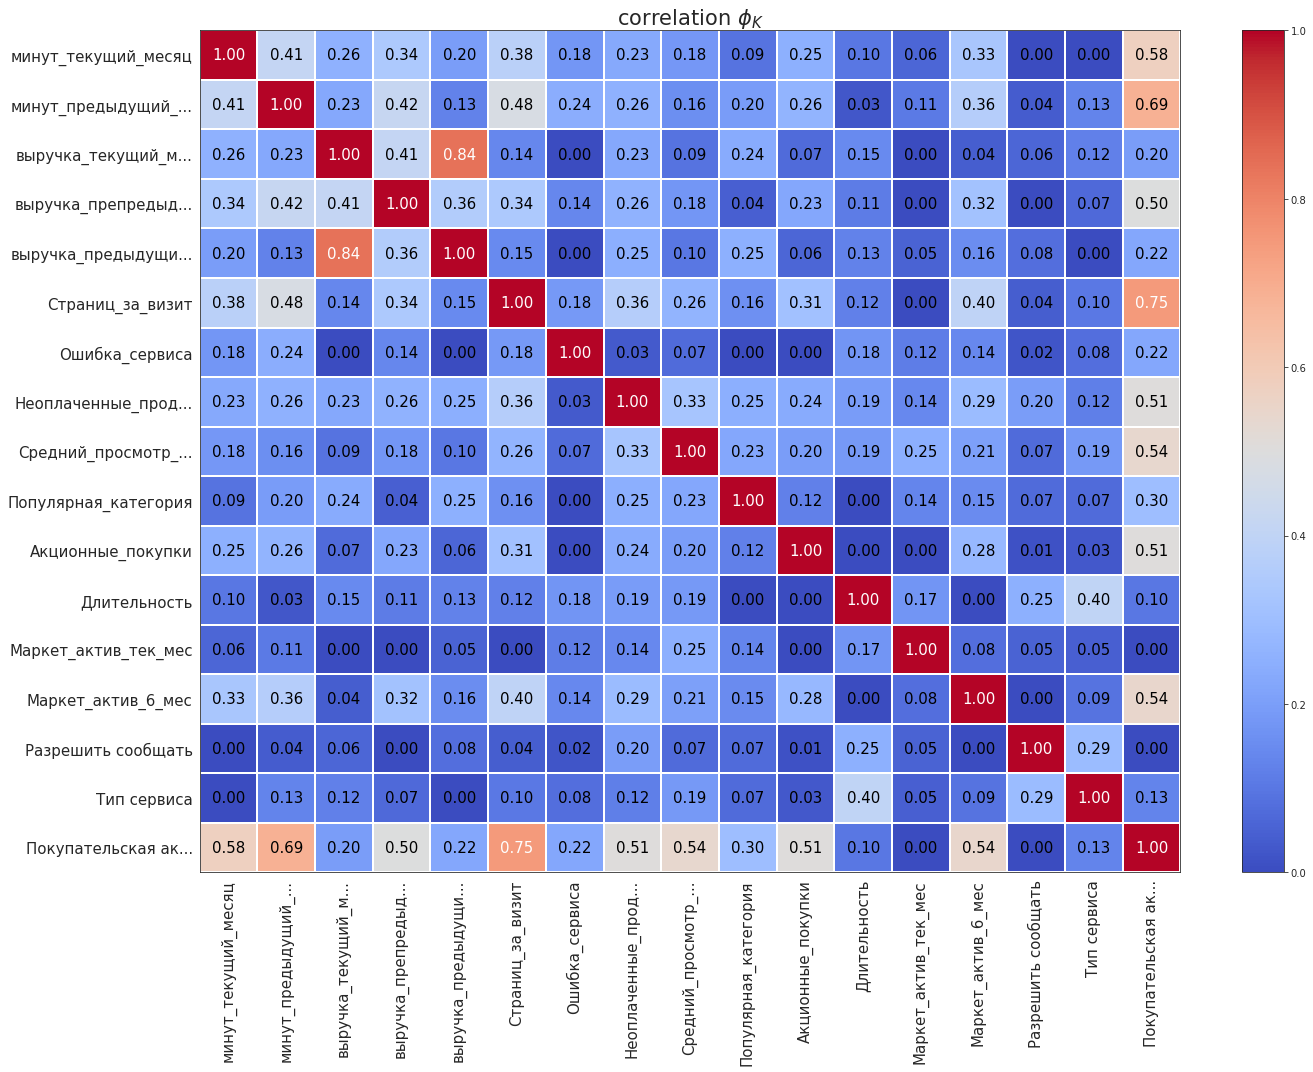

In [296]:
corr_matrix = phik_matrix(df) 
plot_correlation_matrix(
    corr_matrix.values,
    x_labels=corr_matrix.columns,
    y_labels=corr_matrix.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)
plt.show();

**Выводы:**
- из корреляционной матрицы видно, что с целевым признаком `Покупательская активность` сильно коррелируют признаки `Страниц за визит` и `минуты на сайте в предыдущем месяце` - это выглядит логичным.
- признаков с корреляцией близкой к 1 не наблюдается.

## Моделирование и использование пайплайнов

In [297]:
def categorize_activity(row):
    if row == 'Снизилась':
        return 1
    else:
        return 0

In [298]:
df['Покупательская активность'] = df['Покупательская активность'].apply(categorize_activity)
df.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [299]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Покупательская активность'], axis=1),
    df['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['Покупательская активность'])

ohe_columns = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
              'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
              'Страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
              'минут_предыдущий_месяц', 'минут_текущий_месяц']

ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', sparse=False))])

data_preprocessor = ColumnTransformer([('ohe', ohe_pipe, ohe_columns), ('num', StandardScaler(), num_columns)], 
                                      remainder='passthrough'
                                     )
pipe_final = Pipeline([('preprocessor', data_preprocessor),('models', LogisticRegression(random_state=RANDOM_STATE))])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__min_samples_split': range(2, 6),
        'models__min_samples_leaf': range(1, 6),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num', 'passthrough',
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                               

In [300]:
pipe_final.named_steps['preprocessor'].fit_transform(X_train)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_train_scale = pd.DataFrame(pipe_final.named_steps['preprocessor'].fit_transform(X_train), columns = feature_names)
X_test_scale = pd.DataFrame(pipe_final.named_steps['preprocessor'].transform(X_test), columns = feature_names)

In [301]:
y_test_pred_proba = randomized_search.best_estimator_.named_steps['models'].predict_proba(X_test_scale)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.8797476034461837


X has feature names, but LogisticRegression was fitted without feature names


**Выводы:**
- Лучшая модель при рандомизированном поиске - логистическая с l1 регуляризацией с параметром С=3;
- метрика ROC-AUC на тренировочной выборке 0,90, на тестовой 0,86 - хороший показатель.


Для оенки модели используем метрику ROC-AUC в связи с тем, что:
- нам необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности;
- целевой признак не сбалансирован (60% на 40%);
- у нас не стоит задачи не допускать ошибки FN или FP.

## Анализ важности признаков

### Матрица ошибок

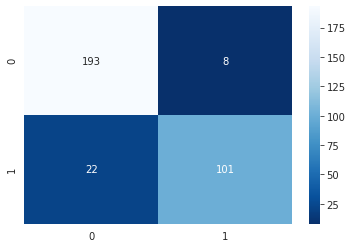

In [320]:
cm = confusion_matrix(y_test, randomized_search.best_estimator_.named_steps['models'].predict(X_test_scale))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

**Выводы**
- видно что модель допускает больше ошибок второго рода (22 ошибок), чем первого рода (8 ошибок).

### Коэффициенты модели

In [303]:
for feature_number, feature_name in enumerate(feature_names):
    exp_weight = math.exp(randomized_search.best_estimator_.named_steps['models'].coef_[0, feature_number])
    display(f"{feature_name:<65}: {exp_weight:+.4f}")

'ohe__Тип сервиса_стандарт                                        : +1.0884'

'ohe__Разрешить сообщать_нет                                      : +0.8931'

'ohe__Популярная_категория_Косметика и аксесуары                  : +0.8083'

'ohe__Популярная_категория_Кухонная посуда                        : +0.7308'

'ohe__Популярная_категория_Мелкая бытовая техника и электроника   : +0.3046'

'ohe__Популярная_категория_Техника для красоты и здоровья         : +0.5206'

'ohe__Популярная_категория_Товары для детей                       : +0.7615'

'num__Маркет_актив_6_мес                                          : +0.6442'

'num__Маркет_актив_тек_мес                                        : +1.0870'

'num__Длительность                                                : +1.0005'

'num__Акционные_покупки                                           : +12.5156'

'num__Средний_просмотр_категорий_за_визит                         : +0.6210'

'num__Неоплаченные_продукты_штук_квартал                          : +1.3141'

'num__Ошибка_сервиса                                              : +0.9288'

'num__Страниц_за_визит                                            : +0.8445'

'num__выручка_предыдущий_месяц                                    : +1.0005'

'num__выручка_препредыдущий_месяц                                 : +0.9992'

'num__выручка_текущий_месяц                                       : +0.9996'

'num__минут_предыдущий_месяц                                      : +0.8607'

'num__минут_текущий_месяц                                         : +0.8880'

**Выводы**
- самые высокие коэффициенты у признаков Акционные покупки, Неоплаченные продукты, Длительность.

### Анализ признаков с помощью метода SHAP

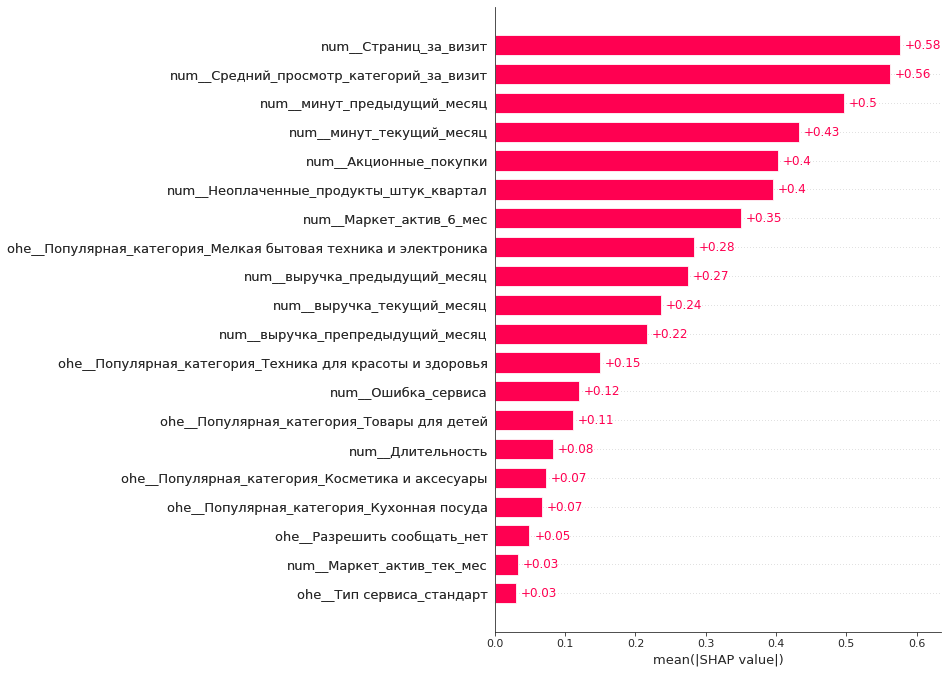

In [304]:
randomized_search.best_estimator_.named_steps['models'].fit(X_train_scale, y_train) 
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_scale)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
shap_values = explainer(X_test_scale)
shap.plots.bar(shap_values, max_display=20)

**Выводы**
- самыми важными признаками для модели являются признаки - Средний просмотр категорий за визит и Страниц за визит.

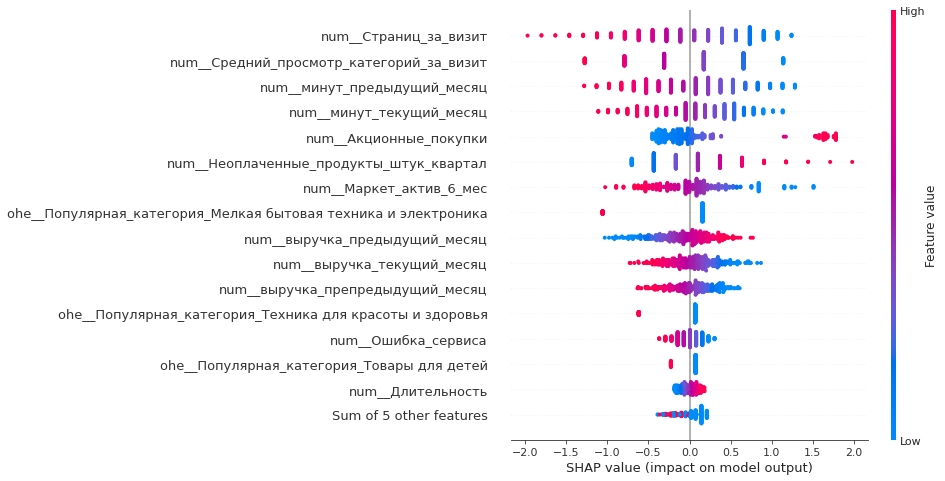

In [305]:
shap.plots.beeswarm(shap_values, max_display=16)

**Выводы**
- чем больше у клиента просмотров категорий и страниц за визит, а также време проведенное на сайте, тем выше верояность того, что покупательская активность данного клиента не изменится - данные признаки это индивидуальное поведение клиента, компании сложно на него повлиять;
- чем больше объем неоплаченных продуктов у клиента, тем выше вероятность, что его покупательская активность снизится - после добавления товаров в корзину покапатель может не оформить заказ по разным причинам, например: не устроила стоимость / срок / время доставки, доставка не работаем по необходимомму адресу, возникли проблемы с оформлением заказа (долгая регистрация / неудобная авторизация), долгий / неудобный процесс оплаты, клиент не видит полной стоимости корзины товаров до его оформления. Рекомендации для компании: 1. максимально упростить процесс оформления и оплаты заказа (оформление без регистрации / разнае способы оплаты) 2. До оформления заказа уведомлять клиента о сроках и стоимости доставки 3. Показывать клиенту итоговую стоимость корзины выбранных товаров.
- интересная зависимость у выручки: чем выше выручка от клиента препредыдущем месяце тем выше вероятность того, что покупательская активность клиента останется на прежнем уровне, при этом чем выручка в предыдущем месяце тем выше вероятность того, что покупательская активность клиента снизится. Вероятно это связано с тем, что у клиентов компании в среднем лаг между покупками 1 месяц. Рекомендации для компании: увеличивать базу постоянных клиентов путем рекламы / соц.сетей / положительных отзывов на сайте.
- чем выше у клиента доля покупок товаров по акциям, тем выше вероятность снижения покупательской активности. Скорее всего это связано с тем, что акции на товары распространяются на непродолжительный срок и клиенты, которые покупали товар по акции не готовы его покупать по полной цене. Рекомендации для компании: Для клиентов с высокой долей покупок по акциям разработать программу лояльности, таким образов увеличить их покупательскую активность.

### Анализ признаков с помощью метода Permutation importance

<AxesSubplot:ylabel='Feature'>

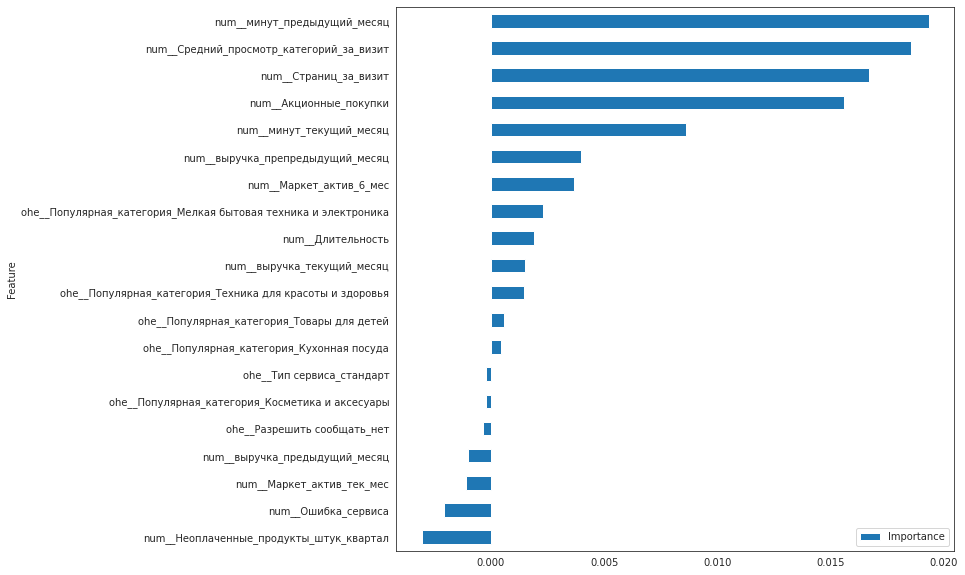

In [306]:
result = permutation_importance(randomized_search.best_estimator_.named_steps['models'], 
                                X_test_scale, y_test, scoring='roc_auc')

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 10)) 

**Выводы**
- оценка методом permutation_importance показывает, что самые важные признака все те же - просмотров категорий и страниц за визит, а также време проведенное на сайте, при этом на первом месте по важности находятся признаки выручка препредыдущем месяце и доля акционных покупок (рекомендации по данным признакам указаны выше).

## Сегментация покупателей

### Объединение таблиц для анализа

In [307]:
y_test_pred = randomized_search.best_estimator_.named_steps['models'].predict(X_test_scale)

In [308]:
df_test = X_test.copy()
df_test['активность_предсказанная'] = y_test_pred.tolist()
df_test.head()

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,активность_предсказанная
id,,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,0
215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,1
216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,0
215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,1
215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,1


Объединяем предсказанную моделью активность покупателей и тестовую выборку.

In [309]:
def cotegorize_income(row):
    if row > money['Прибыль'].median():
        return 'Высокая прибыль'
    else:
        return 'Низкая прибыль'

In [310]:
money['Категория прибыли'] = money['Прибыль'].apply(cotegorize_income)
money.set_index('id')
money.head()

,id,Прибыль,Категория прибыли
0,215348,0.98,Низкая прибыль
1,215349,4.16,Высокая прибыль
2,215350,3.13,Низкая прибыль
3,215351,4.87,Высокая прибыль
4,215352,4.21,Высокая прибыль


In [311]:
df_test = df_test.merge(money, on='id', how = 'left')
df_test.head()

,id,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,активность_предсказанная,Прибыль,Категория прибыли
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,0,4.69,Высокая прибыль
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,1,2.75,Низкая прибыль
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,0,3.16,Низкая прибыль
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,1,3.74,Низкая прибыль
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,1,4.40,Высокая прибыль


Добавляем в таблицу показатели прибыльности.

### Сегментация покупателей

Для сегментации выбираем группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

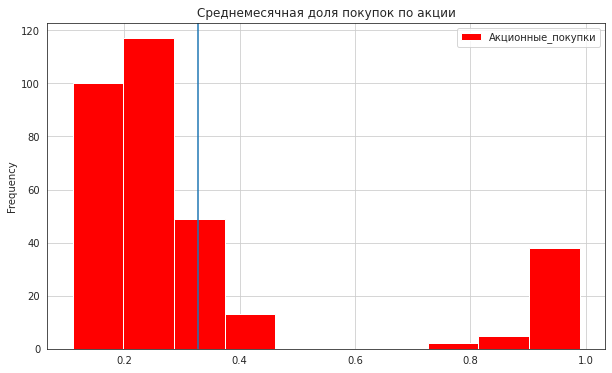

count    324.000000
mean       0.327099
std        0.254989
min        0.110000
25%        0.170000
50%        0.240000
75%        0.310000
max        0.990000
Name: Акционные_покупки, dtype: float64

In [312]:
df_test['Акционные_покупки'].plot(
    kind = 'hist',
    bins = 10,
    title = 'Среднемесячная доля покупок по акции', 
    legend = True, 
    grid = True,
    figsize = (10, 6),
    color = 'r'
)
plt.axvline (x=df_test['Акционные_покупки'].mean()) 
plt.show();
display(df_test['Акционные_покупки'].describe())

In [313]:
def cotegorize_discont(row):
    if row > 0.6:
        return 'Высокая доля покупок по акции'
    else:
        return 'Низкая доля покупок по акции'

In [314]:
df_test['Категория покупок по акции'] = df_test['Акционные_покупки'].apply(cotegorize_discont)
df_test.head()

,id,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,...,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,активность_предсказанная,Прибыль,Категория прибыли,Категория покупок по акции
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,...,12,3973.0,4912.0,3289.2,16,17,0,4.69,Высокая прибыль,Низкая доля покупок по акции
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,...,6,3548.0,4656.0,4170.7,11,9,1,2.75,Низкая прибыль,Высокая доля покупок по акции
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,...,10,5444.0,4565.0,6335.8,20,11,0,3.16,Низкая прибыль,Низкая доля покупок по акции
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,...,6,6604.0,4993.0,6758.7,9,9,1,3.74,Низкая прибыль,Низкая доля покупок по акции
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,...,7,5090.0,4451.0,5773.8,15,18,1,4.40,Высокая прибыль,Высокая доля покупок по акции


Добавим категорию для клиентов с выкой долей покупок по акции.

### Работа с сегментом

In [315]:
df_test_discont = df_test[df_test['Категория покупок по акции'] == 'Высокая доля покупок по акции']
df_test_discont.shape

(45, 21)

Выделяем сегмент с клиентами с высокой долей покупок по акциям

In [316]:
category_to_bar = ['Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_тек_мес', 'Популярная_категория',
                  'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
                  'Ошибка_сервиса', 'Страниц_за_визит', 'Категория прибыли']
category_to_hist = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'выручка_предыдущий_месяц',
                  'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
                  'минут_предыдущий_месяц', 'минут_текущий_месяц']

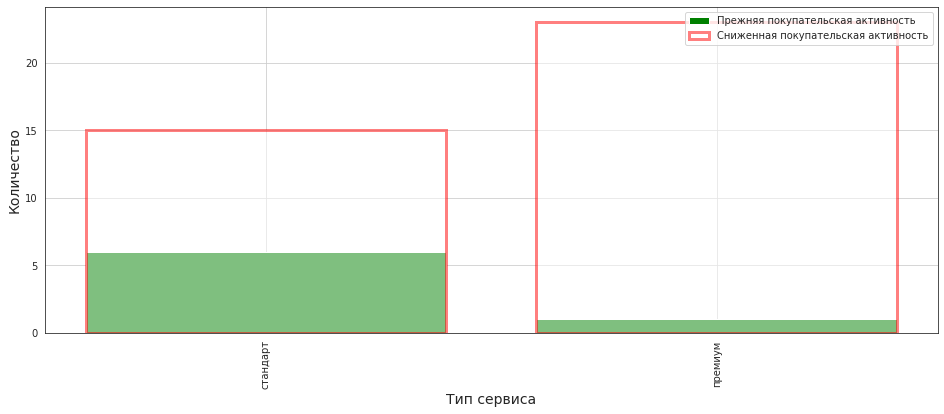

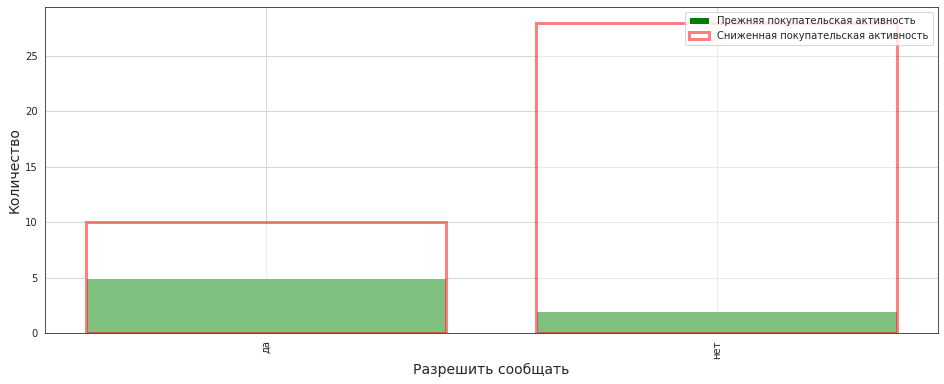

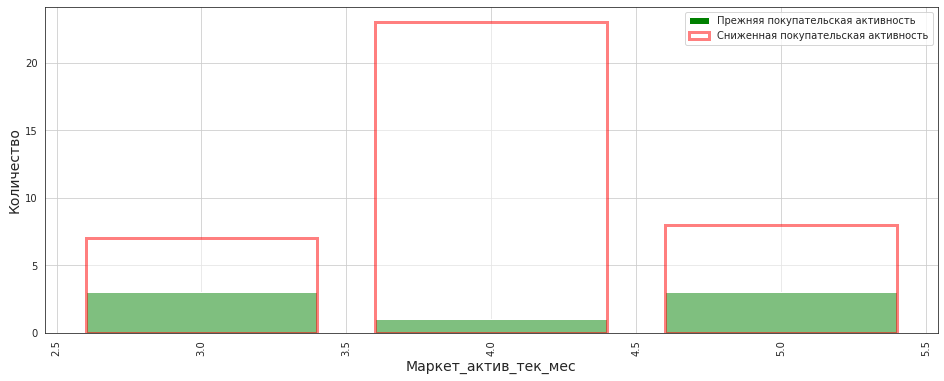

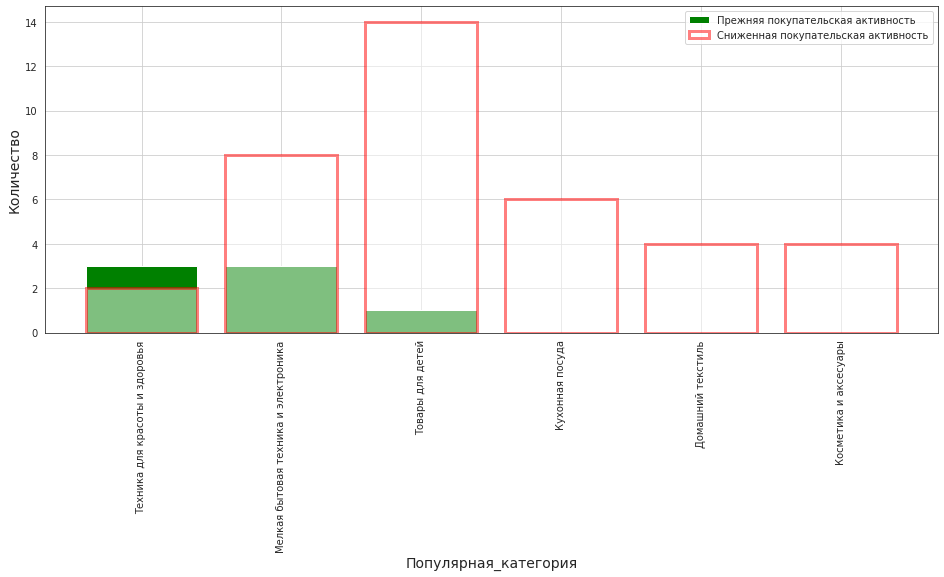

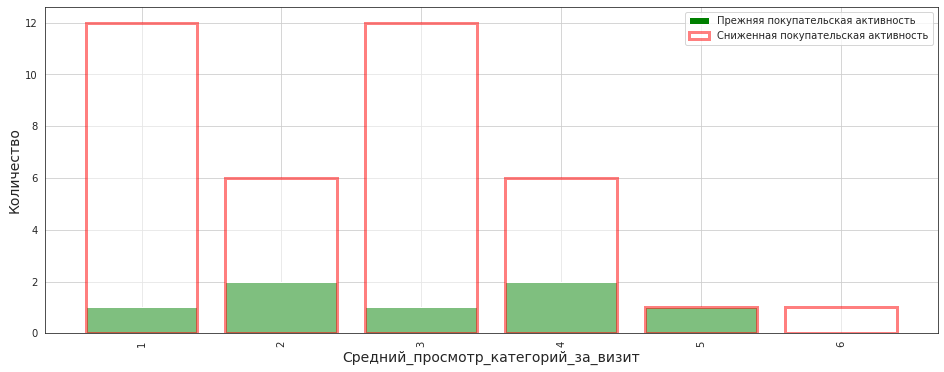

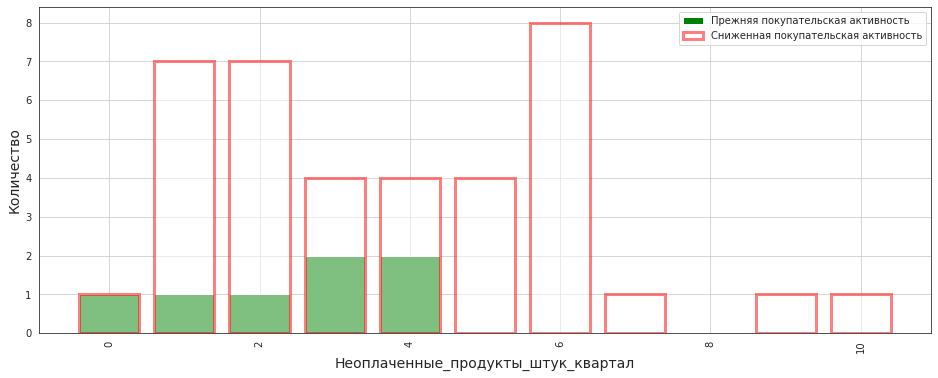

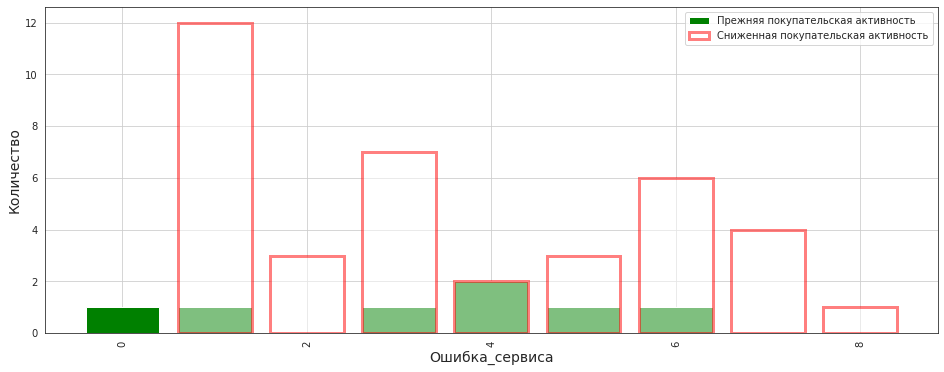

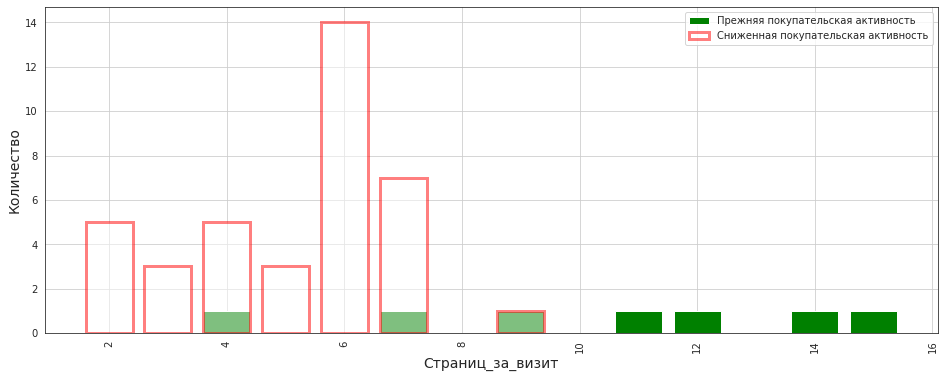

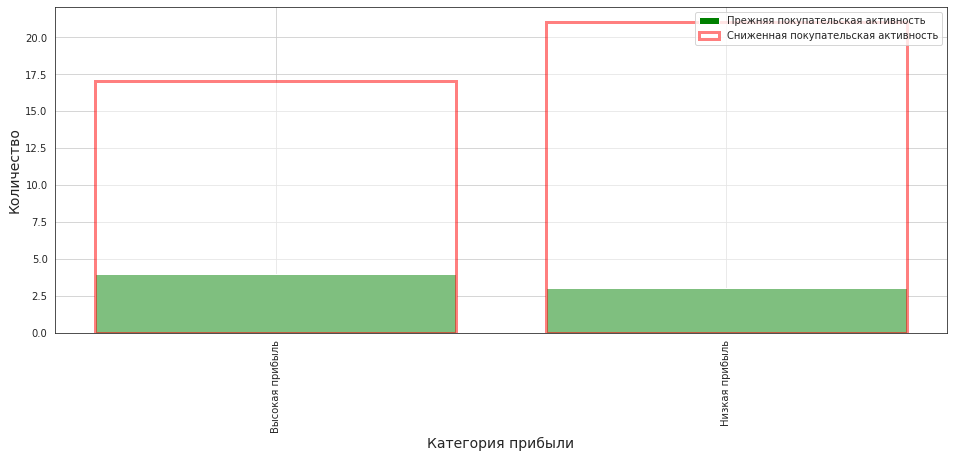

In [317]:
for category in category_to_bar:
    plt.figure(figsize=(16, 6))
    plt.bar(df_test_discont[df_test_discont['активность_предсказанная'] == 0][category].unique(), 
         df_test_discont[df_test_discont['активность_предсказанная'] == 0][category].value_counts(),
         alpha=1, label='Прежняя покупательская активность', facecolor='g')
    plt.bar(df_test_discont[df_test_discont['активность_предсказанная'] == 1][category].unique(),
         df_test_discont[df_test_discont['активность_предсказанная'] == 1][category].value_counts(),
         alpha=0.5, label='Сниженная покупательская активность', facecolor='w', edgecolor = 'r', linewidth = 3)
    plt.legend(loc='upper right')
    plt.xlabel(category, fontsize=14)
    plt.ylabel('Количество', fontsize=14)
    plt.grid(True)
    plt.tick_params(labelsize=10)
    plt.xticks(rotation=90)
    plt.show();

**Выводы**
- большинство графиков подтверждает тезисы изложенные относительно всей выборки (п. 7.3 проекта).
- видно, что клиенты покупающие категории товаров длительного пользование с большой вороятность снизят свою покупальную активность. Можно предложить следующую рекомендацию: давать рекламу товаров короткого пользования и привлекать клиентов скадками на данные товары.
- видно, что если клиент не оплатил более 5 товаров, то вероятность снижения покупательской активности практически 100%. Помимо указанных в п. 7.3 проекта причин, на это может повлиять то, что клиент добавил товары в корзину в ожидании скидок на данные товары и не оплачивает товары до появления скидок. Можно предложить следующую рекомендацию: (помимо указанных в п. 7.3) направлять таким клиентам спустя некоторое время (1-3 дня) предложение купить выбранные, но неоплаченные товары с некоторой скидкой.

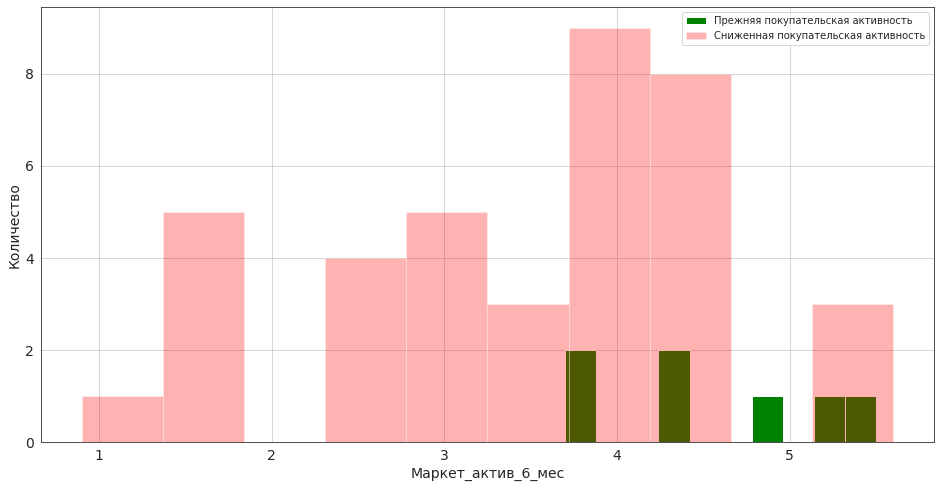

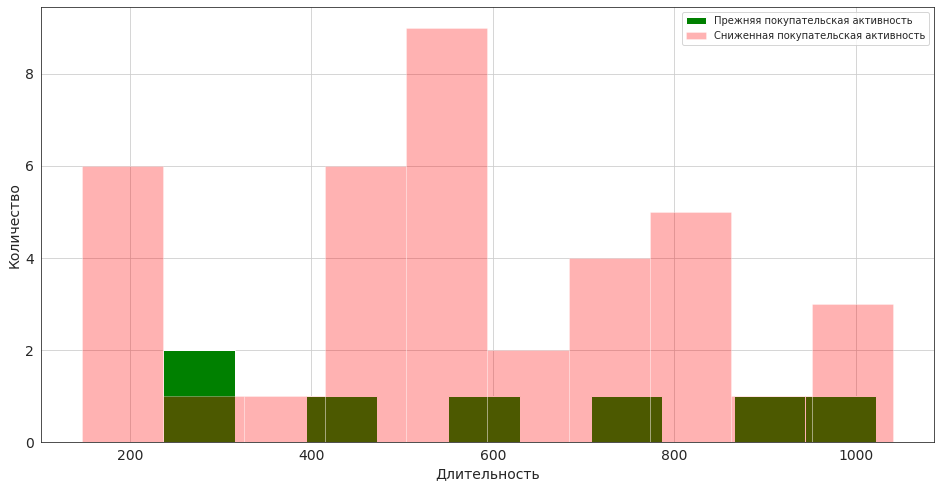

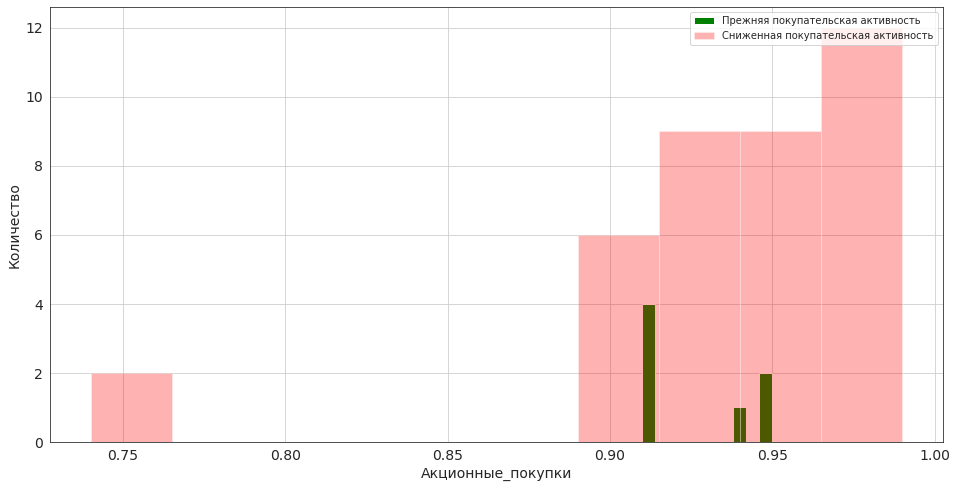

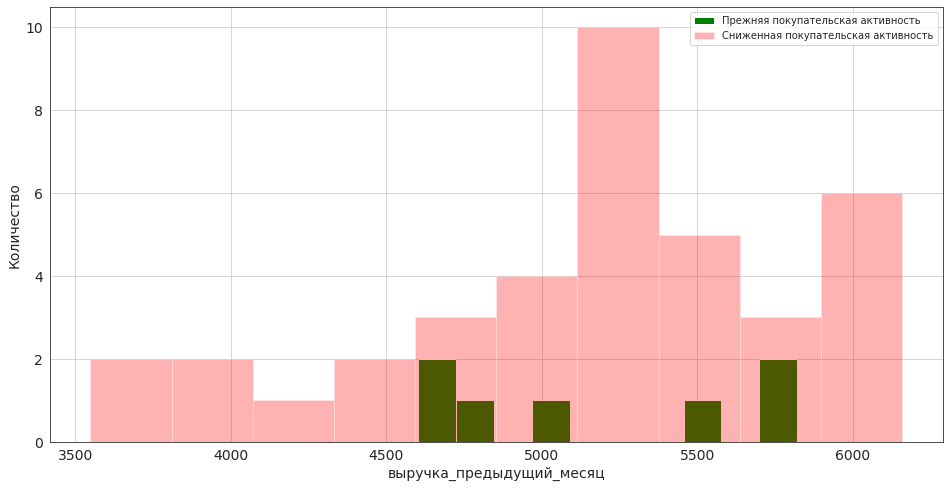

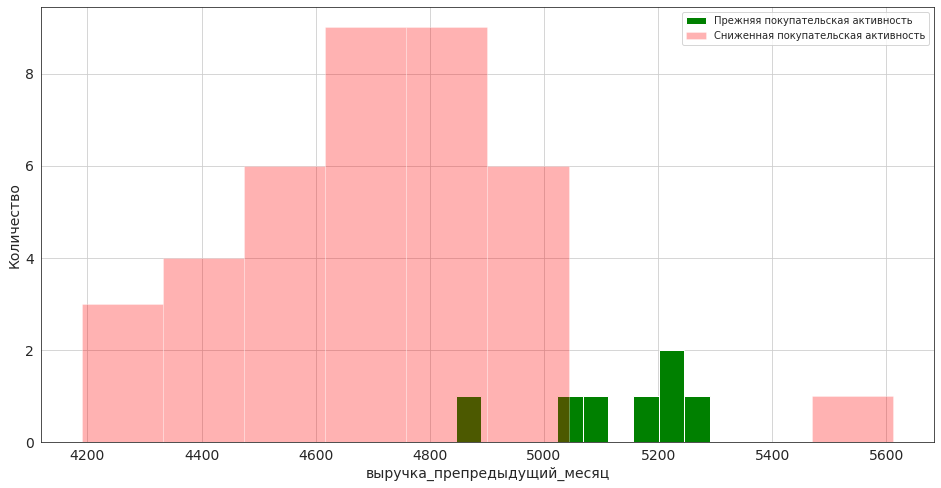

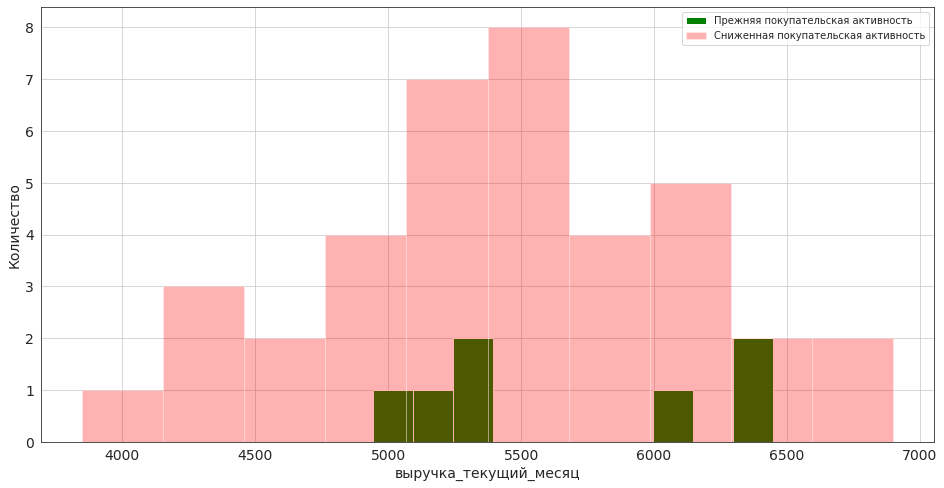

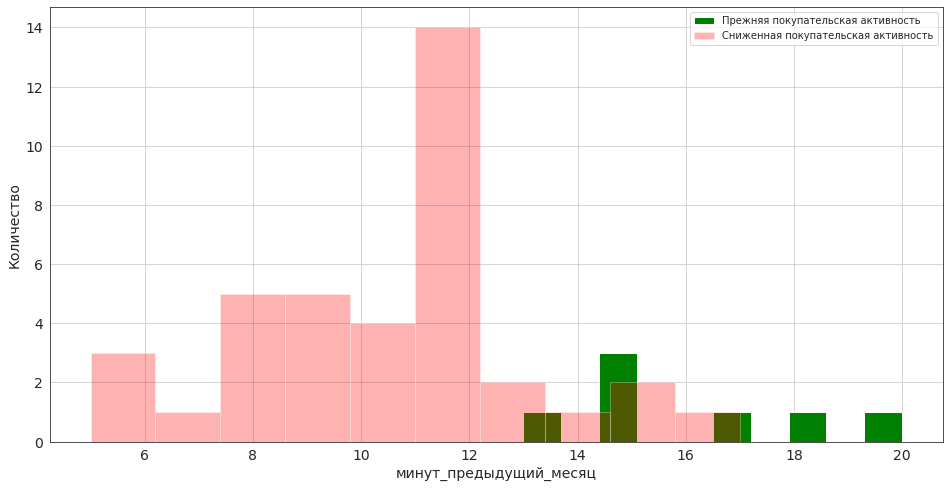

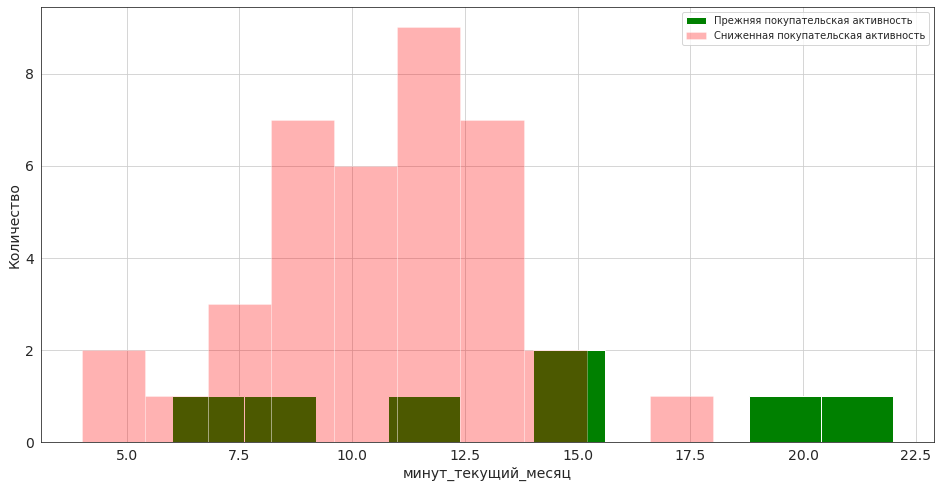

In [318]:
for category in category_to_hist:
    plt.figure(figsize=(16, 8))
    plt.hist(df_test_discont[df_test_discont['активность_предсказанная'] == 0][category],
         bins=10, alpha=1, label='Прежняя покупательская активность', facecolor='g')
    plt.hist(df_test_discont[df_test_discont['активность_предсказанная'] == 1][category], 
         bins=10, alpha=0.3, label='Сниженная покупательская активность', facecolor='r')
    plt.legend(loc='upper right')
    plt.xlabel(category, fontsize=14)
    plt.ylabel('Количество', fontsize=14)
    plt.grid(True)
    plt.tick_params(labelsize=14)
    plt.show();

**Выводы**
- на данных графиках видно, что боольшиство клиентов покупают товары длительного пользования и их активность при покупках в предыдущих месяцах снижается.

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц', 'активность_предсказанная', 'Прибыль']


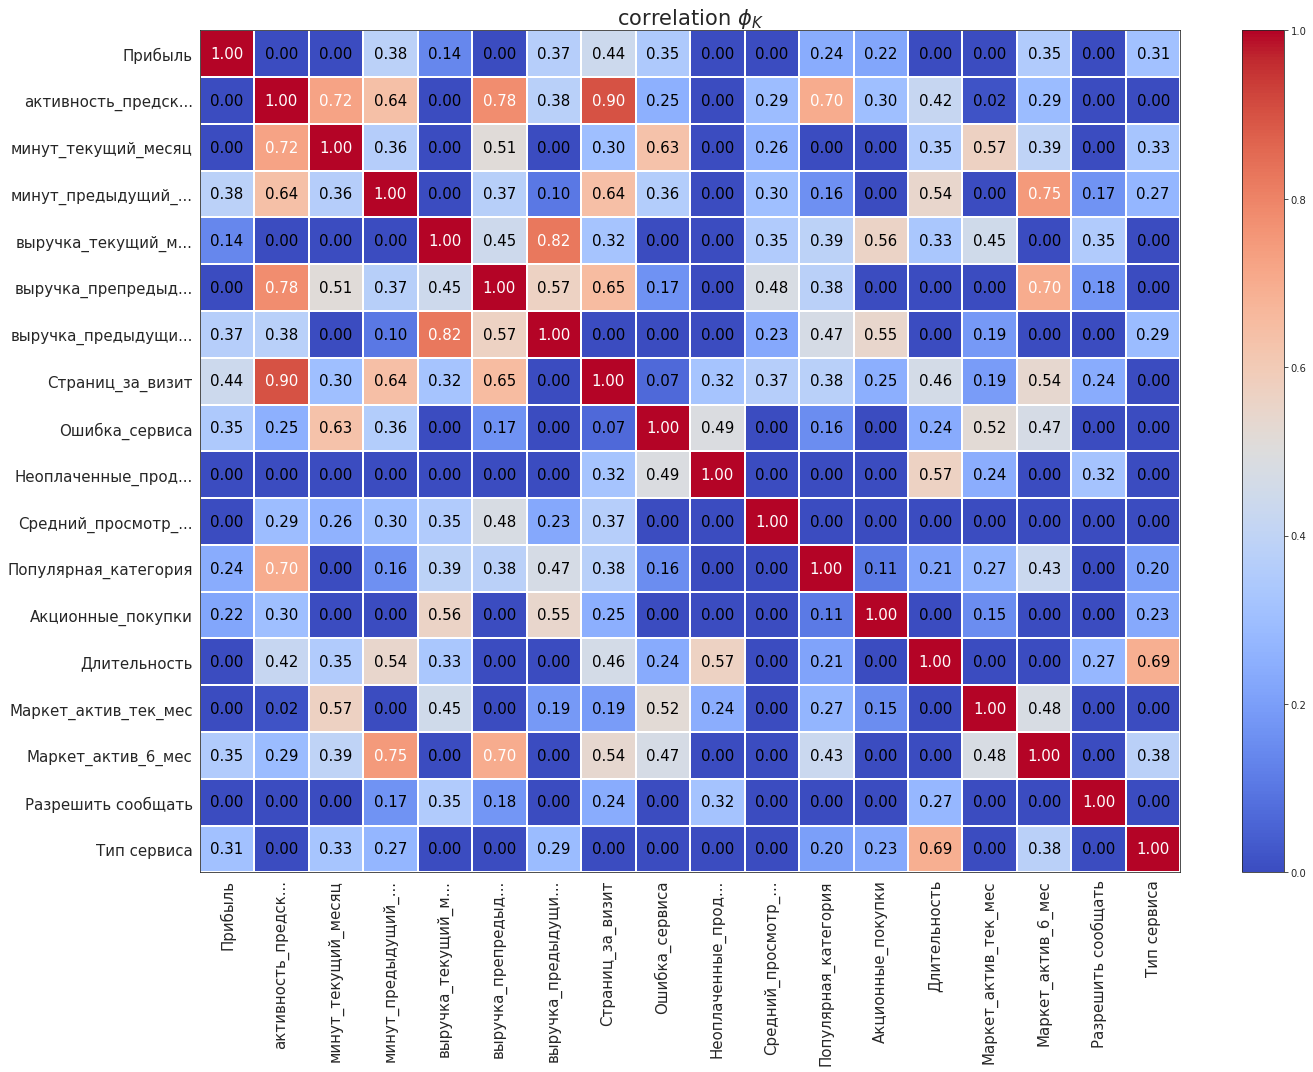

In [319]:
corr_matrix2 = phik_matrix(df_test_discont.drop(['id', 'Категория покупок по акции', 'Категория прибыли'], axis=1)) 
plot_correlation_matrix(
    corr_matrix2.values,
    x_labels=corr_matrix2.columns,
    y_labels=corr_matrix2.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)
plt.show();

**Выводы**
- корреляционная матрица похожа на матрицу общей выборки.

## Общий вывод

**Описание проекта**

Мы получили данные данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении и о прибыли, которую получает магазин от продаж каждому покупателю за последние 3 мес.

Задача — разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Результаты предобработки данных**

При исследовании данных были обнаружены следующие выбросы:

- в датафрейме с данными о прибыли с клиентов обраружен клиент с нетиписным размером выручки - более 100 тыс. руб., данный клиент был удален из выборки.

Больше отсутствующих / дублирующихся / анамальных данных не было обнаружено.

**Обучение и результаты моделей**

С помощью паплайна было обучено 4 модели для покупательной активности - KNN, дерево решений, логистическая регрессия и SVC:
1. Категориальные данные были преобразованы с помощью OneHotEncoder, количественные переменные масштабированы с помощью нескольких методов - StandardScaler, MinMaxScaler и без масштабирования.
2. Во всех перечисленных моделях с помошью пайплайна и перебиралось несколько гиперпараметров.
3. В качесве метрики выбрана матрика ROC-AUC в связи с тем, что нам необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности, целевой признак не сбалансирован (60% на 40%) и у нас не стоит задачи не допускать ошибки FN или FP.

Лучшая модель была найдена с помощью рандомизированного поиска:
- лучшая модель - логистическая регрессия с гиперпараметрами: регуляризация - l1, сила регуляризвции - С=3, solver=liblinear (т.к. выборка небольшая).

**Итог**

*Общий вывод:*
1. Чем больше объем неоплаченных продуктов у клиента, тем выше вероятность, что его покупательская активность снизится - после добавления товаров в корзину покапатель может не оформить заказ по разным причинам, например: не устроила стоимость / срок / время доставки, доставка не работаем по необходимомму адресу, возникли проблемы с оформлением заказа (долгая регистрация / неудобная авторизация), долгий / неудобный процесс оплаты, клиент не видит полной стоимости корзины товаров до его оформления.

Рекомендации для компании: 
- максимально упростить процесс оформления и оплаты заказа (оформление без регистрации / разнае способы оплаты) 
- до оформления заказа уведомлять клиента о сроках и стоимости доставки 
- показывать клиенту итоговую стоимость корзины выбранных товаров.
2. Выявлена следующая зависимость у выручки: чем выше выручка от клиента препредыдущем месяце тем выше вероятность того, что покупательская активность клиента останется на прежнем уровне, при этом чем выручка в предыдущем месяце тем выше вероятность того, что покупательская активность клиента снизится. Вероятно это связано с тем, что у клиентов компании в среднем лаг между покупками 1 месяц. 

Рекомендации для компании: 
- увеличивать базу постоянных клиентов путем рекламы / соц.сетей / положительных отзывов на сайте.
3. чем выше у клиента доля покупок товаров по акциям, тем выше вероятность снижения покупательской активности. Скорее всего это связано с тем, что акции на товары распространяются на непродолжительный срок и клиенты, которые покупали товар по акции не готовы его покупать по полной цене. 

Рекомендации для компании: 
- Для клиентов с высокой долей покупок по акциям разработать программу лояльности, таким образом увеличить их покупательскую активность.

*Вывод для клиентов с высокой долей покупок по акциям:*
1. Клиенты покупающие категории товаров длительного пользования с большой вороятностью снизят свою покупальную активность.

Рекомендации для компании: 
- давать рекламу товаров кратковременного пользования и привлекать клиентов скадками на данные товары.
2. Если клиент не оплатил более 5 товаров, то вероятность снижения покупательской активности практически 100%. Это может быть связано с тем, что клиент добавил товары в корзину в ожидании скидок на данные товары и не оплачивает их до появления скидок.

Рекомендации для компании:
- направлять таким клиентам спустя некоторое время (1-3 дня) предложение купить выбранные, но неоплаченные товары, с некоторой скидкой.